In [92]:
import pandas as pd
import numpy
import numpy.random as nrand
import math

def vol(returns):
    # Return the standard deviation of returns
    return numpy.std(returns)

def lpm(returns, threshold, order):
    # This method returns a lower partial moment of the returns
    # Create an array he same length as returns containing the minimum return threshold
    threshold_array = numpy.empty(len(returns))
    threshold_array.fill(threshold)
    # Calculate the difference between the threshold and the returns
    diff = threshold_array - returns
    # Set the minimum of each to 0
    diff = diff.clip(min=0)
    # Return the sum of the different to the power of order
    return numpy.sum(diff ** order) / len(returns)

# 10% per year seems reasonable
expected_return = .10 / 365

#consider using futures premium / lending yield as rf going forward
def sharpe_ratio(returns, er=expected_return, risk_free=0):
    return (er - risk_free) / vol(returns)

def sortino_ratio(returns, er=expected_return, risk_free=0, target=0):
    return (er - risk_free) / math.sqrt(lpm(returns, target, 2))

def add_return_metrics(df):
    df['returns'] = df['open'].pct_change(1)
    df['volatility'] = df['returns'].rolling(window=5, center=False).std()
    df['sharpe ratio'] = df['returns'] / df['volatility']
    df['prev sharpe ratio'] = df['sharpe ratio'].shift(1)
    df.dropna(inplace=True)

In [93]:
# check how the data is structured from some samples
btc_usd = pd.read_pickle('../data/prices/BTC_USD_daily.pkl', compression='xz')
btc_usd.head()

,averagePrice,bucket,close,exchange,high,low,open,time,volume
0,601.263103,86400,603.00,cexio,617.79,550.0,550.00,2014-07-18T00:00:00.000Z,3130.441304
1,609.896701,86400,613.97,cexio,617.00,603.0,613.00,2014-07-19T00:00:00.000Z,3600.678976
2,608.229716,86400,603.07,cexio,613.00,603.0,603.02,2014-07-20T00:00:00.000Z,3265.066020
3,605.354613,86400,603.15,cexio,613.00,603.0,603.06,2014-07-21T00:00:00.000Z,1717.027527
4,604.394635,86400,611.00,cexio,611.85,603.0,604.00,2014-07-22T00:00:00.000Z,2998.767348


In [6]:
# just the columns
btc_usd.columns

Index(['averagePrice', 'bucket', 'close', 'exchange', 'high', 'low', 'open',
       'time', 'volume'],
      dtype='object')

In [61]:
# use timestamp as index and remove duplicate timestamps
btc_usd = btc_usd.set_index(pd.DatetimeIndex(btc_usd['time']))
btc_usd = btc_usd[~btc_usd.index.duplicated(keep='first')]
btc_usd.head()

,averagePrice,bucket,close,exchange,high,low,open,time,volume
time,,,,,,,,,
2014-07-18,601.263103,86400,603.00,cexio,617.79,550.0,550.00,2014-07-18T00:00:00.000Z,3130.441304
2014-07-19,609.896701,86400,613.97,cexio,617.00,603.0,613.00,2014-07-19T00:00:00.000Z,3600.678976
2014-07-20,608.229716,86400,603.07,cexio,613.00,603.0,603.02,2014-07-20T00:00:00.000Z,3265.066020
2014-07-21,605.354613,86400,603.15,cexio,613.00,603.0,603.06,2014-07-21T00:00:00.000Z,1717.027527
2014-07-22,604.394635,86400,611.00,cexio,611.85,603.0,604.00,2014-07-22T00:00:00.000Z,2998.767348


In [94]:
# ADD volatility and sharpe ratios
add_return_metrics(btc_usd)
btc_usd.head()

,averagePrice,bucket,close,exchange,high,low,open,time,volume,returns,volatility,sharpe ratio,prev sharpe ratio
6,612.073782,86400,614.820,cexio,615.00,604.00000,614.000,2014-07-24T00:00:00.000Z,23595.710610,0.006574,0.010104,0.650604,0.188473
7,613.180623,86400,615.000,cexio,617.00,604.40000,614.820,2014-07-25T00:00:00.000Z,5701.384625,0.001336,0.004187,0.318993,0.650604
8,611.411936,86400,607.251,cexio,617.00,607.00000,615.000,2014-07-26T00:00:00.000Z,9612.012684,0.000293,0.004136,0.070788,0.318993
9,607.220957,86400,607.880,cexio,615.98,603.50001,607.251,2014-07-27T00:00:00.000Z,6454.148448,-0.012600,0.008604,-1.464464,0.070788
10,601.648127,86400,601.500,cexio,614.49,598.00000,605.880,2014-07-28T00:00:00.000Z,24078.678652,-0.002258,0.007073,-0.319223,-1.464464


In [95]:
#load all pairs
pairs = pd.read_pickle('../data/prices/pairs.pkl')
daily_prices = {}
for index, row in pairs.iterrows():
    key = '{}_{}'.format(row['primary'], row['secondary'])
    test = pd.read_pickle('../data/prices/{}_daily.pkl'.format(key), compression='xz')
    daily_prices[key] = pd.read_pickle('../data/prices/{}_daily.pkl'.format(key), compression='xz')
    daily_prices[key] = daily_prices[key].set_index(pd.DatetimeIndex(daily_prices[key]['time']))
    daily_prices[key] = daily_prices[key][~daily_prices[key].index.duplicated(keep='first')]
    add_return_metrics(daily_prices[key])

In [96]:
# get pairs that are to USD, use to normalize non usd to usd
usd_pairs = []
for index, row in pairs.iterrows():
    secondary = row['secondary']
    if 'USD' in secondary:
        usd_pairs.append('{}_{}'.format(row['primary'], row['secondary']))
usd_pairs

['LTC_USDT',
 'ZEC_USDT',
 'XMR_USDT',
 'DASH_USDT',
 'BNB_USDT',
 'BCC_USDT',
 'ETH_USDT',
 'XRP_USDT',
 'NEO_USDT',
 'BTC_USD',
 'ETH_USD',
 'BTC_USDT',
 'ETC_USDT']

# Lets explore the relationship between returns and previous sharpe ratio

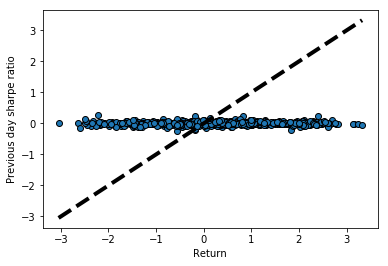

In [112]:
import matplotlib.pyplot as plt

features = ['prev sharpe ratio']
target = ['returns']

BTC = daily_prices['BTC_USD'][['prev sharpe ratio', 'returns']]

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

regr = make_pipeline(
    StandardScaler(),
    linear_model.LinearRegression()
)

X_train, X_test, y_train, y_test = train_test_split(
    BTC[features],
    BTC[target],
    shuffle=False,
    test_size=0.3
)

y = BTC[features]
fig, ax = plt.subplots()
ax.scatter(y, BTC[target], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Return')
ax.set_ylabel('Previous day sharpe ratio')
plt.show()



## Train the model and scatter plot to get a sense if there is a relationship

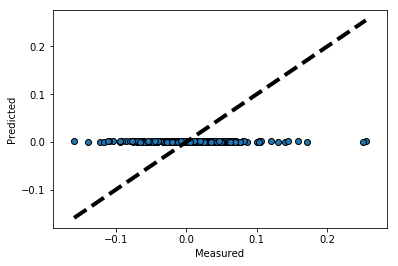

In [105]:
import matplotlib.pyplot as plt

regr.fit(X_train, y_train)
predictions = regr.predict(X_test)

y = y_test
fig, ax = plt.subplots()
ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


## Based on scatter plot there seems to be very little relationship